#### Import libraries and helpers

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import time
import os
import joblib
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    StratifiedShuffleSplit,
    GridSearchCV
)


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    mean_squared_error
)


#### Loading data

In [2]:


# Paths (adjust if your dataset folder differs)
X = np.load('ships_dataset/ship_data.npy')
t = np.load('ships_dataset/ship_labels.npy')

print(f"Data shape: {X.shape}")   # (4000, 80, 80, 3)
print(f"Labels shape: {t.shape}") # (4000,)


Data shape: (4000, 80, 80, 3)
Labels shape: (4000,)


#### Data visualization 

{0: 3000, 1: 1000}


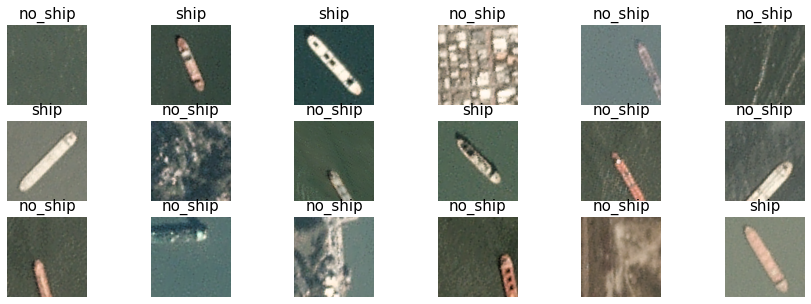

In [3]:
# Verify label distribution
unique, counts = np.unique(t, return_counts=True)
print(dict(zip(unique, counts)))

label_names = ['no_ship', 'ship']

# Random 18 images (ship + no_ship mixed)
rnd_idx = npr.permutation(len(X))[:18]

fig = plt.figure(figsize=(15,5))
for j in range(18):
    fig.add_subplot(3,6,j+1)
    plt.imshow(X[rnd_idx[j]])
    plt.axis('off')
    plt.title(label_names[t[rnd_idx[j]]], size=15)

plt.show()



data imbalance is there , there for mostly use the startified classifification

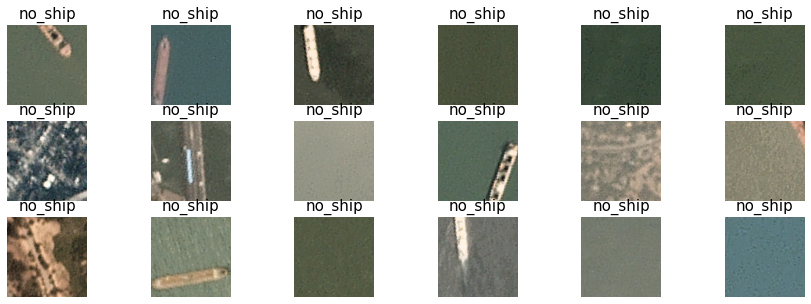

In [4]:
# no_ship images

rnd_sample = npr.permutation(np.where(t==0)[0])
fig=plt.figure(figsize=(15,5))
for j in range(18):
    fig.add_subplot(3,6,j+1)
    plt.imshow(X[rnd_sample[j]])
    plt.axis('off');plt.title(label_names[t[rnd_sample[j]]],size=15)
plt.show()
print('\n\n')

### 1. Answer
- Train at least two classifiers without dimensionality reduction on this dataset.
- Carry the standard hyperparameter tuning.
- Report performance measures (accuracy score and f1-score), and training time.

In [5]:
# flattening image 
X_flat = X.reshape(len(X), -1)
print("Flattened shape:", X_flat.shape)


Flattened shape: (4000, 19200)


In [6]:
# splitting into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, t, test_size=0.2, stratify=t, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3200, 19200), (800, 19200), (3200,), (800,))

#### Train at least two classifiers without dimensionality reduction on this dataset.

In [7]:
# Logistic Regression
pipe_lr = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(
        max_iter=2000,
        solver='lbfgs'
    ))
])

# Random Forest
pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])


In [8]:
def measure_inference_time(model, X, repeats=200):
    """Measure avg inference time per sample in milliseconds."""
    idx = np.random.choice(len(X), size=repeats, replace=False)
    t0 = time.time()
    for i in idx:
        model.predict(X[i:i+1])
    total = time.time() - t0
    return (total / repeats) * 1000  # ms


#### Carry the standard hyperparameter tuning.
#### Report performance measures (accuracy score and f1-score), and training time.

In [9]:
# hyper parameter tuning
param_lr = {
    'clf__C': [0.001, 0.01, 0.1, 1],
    'clf__penalty': ['l2']
}

param_rf = {
    'clf__n_estimators': [ 50, 100],
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [5, 10],
    'clf__min_samples_leaf': [5, 10], 
}

# Model dictionary
models = {
    'Logistic Regression': {'pipeline': pipe_lr, 'params': param_lr},
    'Random Forest': {'pipeline': pipe_rf, 'params': param_rf}
}

# Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

# Function for inference timing
def measure_inference_time(model, X):
    start = time.time()
    model.predict(X[:200]) 
    end = time.time()
    avg_ms = ((end - start) / 200) * 1000
    return avg_ms

# TRAINING LOOP with MULTI-METRIC GRIDSEARCH

for name, m in models.items():

    print(f"\n{name}\n")

    gs = GridSearchCV(
        estimator=m['pipeline'],
        param_grid=m['params'],
        cv=cv,
        scoring={
            'accuracy': 'accuracy',       
            'f1_macro': 'f1_macro'        
        },
        refit='f1_macro',                
# choose best model based on F1 macro
        n_jobs=-1
    )

    # Total CV Time
    t0 = time.time()
    gs.fit(X_train, y_train)
    total_cv_time = time.time() - t0

    # Best model
    best_model = gs.best_estimator_
    print("Best Parameters:", gs.best_params_)

    # Fit on full training set
    t1 = time.time()
    best_model.fit(X_train, y_train)
    best_fit_time = time.time() - t1

    # OFFICIAL VALIDATION PERFORMANCE (From MULTI-METRIC CV)
    cv_f1 = gs.cv_results_['mean_test_f1_macro'][gs.best_index_]
    cv_accuracy = gs.cv_results_['mean_test_accuracy'][gs.best_index_]

    print(f"\nMean CV Accuracy Score: {cv_accuracy:.4f}")
    print(f"Mean CV F1 Score: {cv_f1:.4f}")


   
     #  TRAINING PERFORMANCE (DIAGNOSTIC) 
    y_train_pred = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')

    print(f"\nTraining Accuracy: {train_accuracy:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}")
   

    print("\nTraining Classification Report:")
    print(classification_report(
        y_train,
        y_train_pred,
        target_names=["no_ship", "ship"],
        digits=4
    ))

    # Save model
    filename = f"best_{name.replace(' ', '_')}_noDR.pkl"
    joblib.dump(best_model, filename)

    # Inference time
    inference_time = measure_inference_time(best_model, X_train)

    print(f"Total CV Time: {total_cv_time:.2f} sec")
    print(f"Best Fit Time: {best_fit_time:.2f} sec")
    print(f"Inference Time (per sample): {inference_time:.4f} ms")
    print(f"Saved model : {filename}")

    results.append([
        name,              
        gs.best_params_,    
        cv_accuracy,       
        cv_f1,              
        train_accuracy,     
        train_f1,           
        total_cv_time,      
        best_fit_time,      
        inference_time,     
        filename            
    ])


# Summary Table

df_results = pd.DataFrame(
    results,
    columns=[
        'Model',
        'Best Params',
        'CV Accuracy (mean)',
        'CV F1 (mean)',
        'Train Accuracy',
        'Train F1',
        'Total CV Time (s)',
        'Best Fit Time (s)',
        'Inference Time (ms)',
        'Saved File'
    ]
)

print("\n FINAL SUMMARY ")
display(df_results)


Logistic Regression

Best Parameters: {'clf__C': 0.001, 'clf__penalty': 'l2'}

Mean CV Accuracy Score: 0.9275
Mean CV F1 Score: 0.9021

Training Accuracy: 0.9622
Training F1 Score: 0.9483

Training Classification Report:
              precision    recall  f1-score   support

     no_ship     0.9634    0.9871    0.9751      2400
        ship     0.9582    0.8875    0.9215       800

    accuracy                         0.9622      3200
   macro avg     0.9608    0.9373    0.9483      3200
weighted avg     0.9621    0.9622    0.9617      3200

Total CV Time: 146.11 sec
Best Fit Time: 7.98 sec
Inference Time (per sample): 0.0296 ms
Saved model : best_Logistic_Regression_noDR.pkl

Random Forest

Best Parameters: {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}

Mean CV Accuracy Score: 0.9475
Mean CV F1 Score: 0.9277

Training Accuracy: 0.9938
Training F1 Score: 0.9917

Training Classification Report:
              precision    recal

,Model,Best Params,CV Accuracy (mean),CV F1 (mean),Train Accuracy,Train F1,Total CV Time (s),Best Fit Time (s),Inference Time (ms),Saved File
0,Logistic Regression,"{'clf__C': 0.001, 'clf__penalty': 'l2'}",0.927500,0.902104,0.962187,0.948289,146.114487,7.984526,0.029565,best_Logistic_Regression_noDR.pkl
1,Random Forest,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.947501,0.927730,0.993750,0.991660,132.554107,6.722876,0.063884,best_Random_Forest_noDR.pkl


### 2. answer
Train a pipeline to perform dimensionality reduction with Principal Component Analysis (PCA). Answer the following questions:
How many components are needed to explain 90% of the variance?
Visualize examples of "ship" and "no_ship" image reconstructions. What is the average RMSE of the reconstruction as a function of number of components preserved?

#### Train a pipeline to perform dimensionality reduction with Principal Component Analysis (PCA)

In [10]:

# Fit PCA with all components
pca_full = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),       
    ('pca', PCA(n_components=None, svd_solver='full'))
])
# center features (PCA needs mean centering)

pca_full.fit(X_train)



Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(svd_solver='full'))])

#### How many components are needed to explain 90% of the variance?

Number of components explaining 90% variance: 107


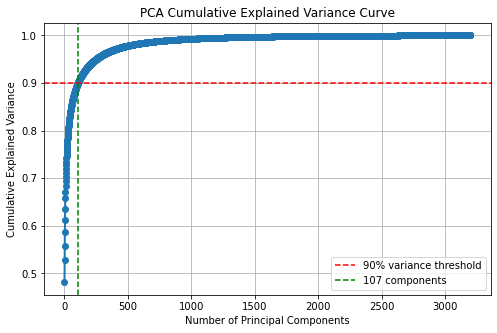

In [11]:
pca = pca_full.named_steps['pca']

# Compute cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_)

#  method to find index where variance >= 90%
# first index meeting condition
idx_90 = np.where(cumvar >= 0.90)[0][0]   

#+1 because components start at 1
n90 = idx_90 + 1                            

print(f"Number of components explaining 90% variance: {n90}")



# Plot cumulative variance curve
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumvar) + 1), cumvar, '-o', linewidth=2)
plt.axhline(0.90, color='red', linestyle='--', label='90% variance threshold')
plt.axvline(n90, color='green', linestyle='--', label=f'{n90} components')

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance Curve")
plt.legend()
plt.grid(True)
plt.show()

#### Visualize examples of "ship" and "no_ship" image reconstructions

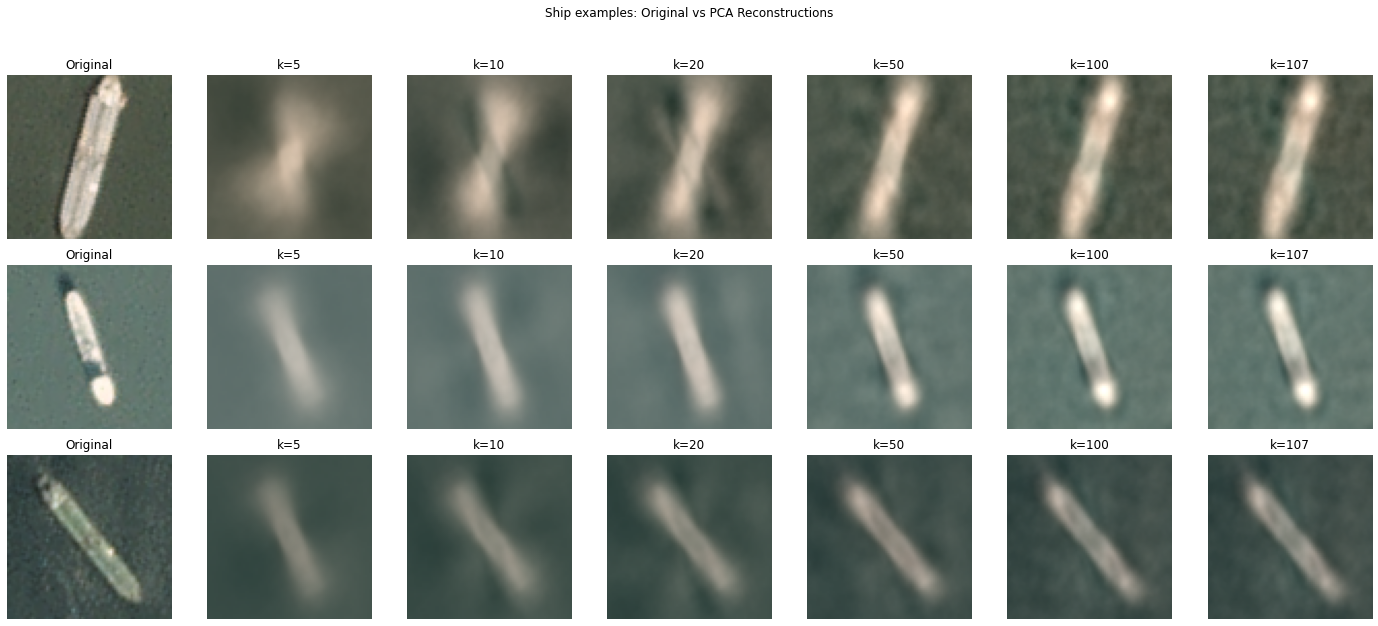

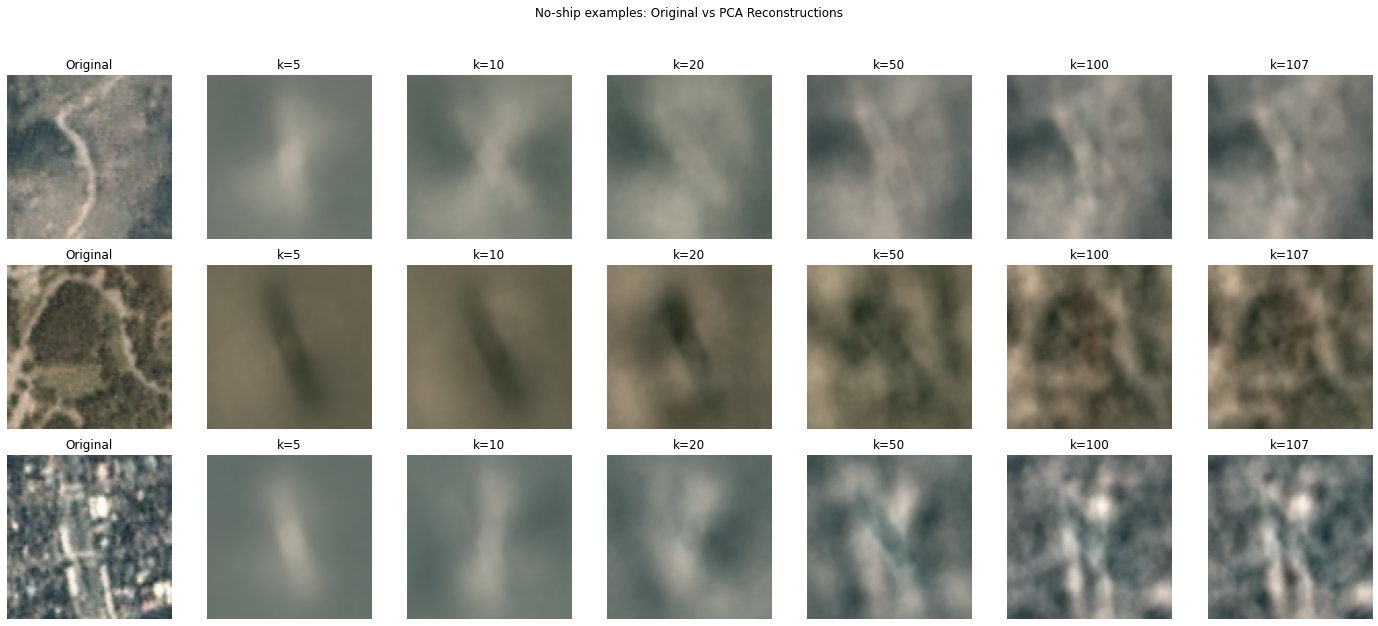

In [12]:
pca = pca_full.named_steps['pca']
scaler = pca_full.named_steps['scaler']

k_list = [5, 10, 20, 50, 100, n90 ]
# recinstruction helper that doesn't refit pca
def reconstruct_with_k(X_batch, k):
    # Scale using the SAME scaler as PCA_full
    X_scaled = scaler.transform(X_batch)

    # Create a truncated PCA using first k components
    pca_k = PCA(n_components=k, svd_solver='full')
    pca_k.components_ = pca.components_[:k]
    pca_k.mean_ = pca.mean_
    pca_k.n_features_in_ = pca.n_features_in_
    pca_k.explained_variance_ = pca.explained_variance_[:k]
    pca_k.explained_variance_ratio_ = pca.explained_variance_ratio_[:k]

    # Project and  reconstruct
    Z = X_scaled @ pca_k.components_.T
    Xhat_scaled = Z @ pca_k.components_ + pca_k.mean_

    # Inverse scale
    Xhat = scaler.inverse_transform(Xhat_scaled)
    return Xhat
rng = np.random.default_rng(42)

ships_idx    = np.where(y_train == 1)[0]
no_ships_idx = np.where(y_train == 0)[0]

ex_ship_idxs = rng.choice(ships_idx, size=3, replace=False)
ex_nosh_idxs = rng.choice(no_ships_idx, size=3, replace=False)

# visualizing ship no ship
def show_recons(idxs, title_prefix):
    H, W, C = 80, 80, 3
    n_img = len(idxs)
    fig, axes = plt.subplots(n_img, len(k_list)+1, 
                             figsize=((len(k_list)+1)*2.8, 2.8*n_img))
    
    for r, idx in enumerate(idxs):
        orig = X_train[idx].reshape(H, W, C)
        axes[r, 0].imshow(orig.astype(np.uint8))
        axes[r, 0].set_title("Original")
        axes[r, 0].axis("off")
        
        for c, k in enumerate(k_list, start=1):
            Xhat = reconstruct_with_k(X_train[idx:idx+1], k)[0].reshape(H, W, C)
            axes[r, c].imshow(np.clip(Xhat, 0, 255).astype(np.uint8))
            axes[r, c].set_title(f"k={k}")
            axes[r, c].axis("off")

    plt.suptitle(f"{title_prefix}: Original vs PCA Reconstructions", y=1.03)
    plt.tight_layout()
    plt.show()

# Show ships & no-ships
show_recons(ex_ship_idxs, "Ship examples")
show_recons(ex_nosh_idxs, "No-ship examples")


#### What is the average RMSE of the reconstruction as a function of number of components preserved?

k=   5  mean RMSE=22.59
k=  10  mean RMSE=19.61
k=  20  mean RMSE=17.11
k=  50  mean RMSE=13.88
k= 100  mean RMSE=11.40
k= 107  mean RMSE=11.20


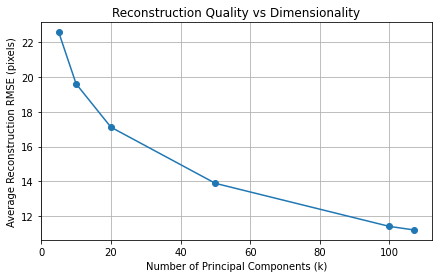

In [13]:
def rmse(a, b):
    return np.sqrt(np.mean((a.astype(np.float32) - b.astype(np.float32))**2))

# Use a manageable stratified sample from TRAIN for the RMSE curve
sample_size_per_class = 150
sub_ship = rng.choice(ships_idx, size=min(sample_size_per_class, len(ships_idx)), replace=False)
sub_nosh = rng.choice(no_ships_idx, size=min(sample_size_per_class, len(no_ships_idx)), replace=False)
sub_idx = np.concatenate([sub_ship, sub_nosh])
X_sub = X_train[sub_idx]

rmse_means = []
for k in k_list:
    Xhat = reconstruct_with_k(X_sub, k)
    # clip to pixel range for a fair pixel-space error
    Xhat = np.clip(Xhat, 0, 255)
    errs = [rmse(X_sub[i], Xhat[i]) for i in range(X_sub.shape[0])]
    rmse_means.append(np.mean(errs))
    print(f"k={k:>4}  mean RMSE={rmse_means[-1]:.2f}")

plt.figure(figsize=(7,4))
plt.plot(k_list, rmse_means, marker='o')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Average Reconstruction RMSE (pixels)')
plt.title('Reconstruction Quality vs Dimensionality')
plt.grid(True)
plt.show()


The reconstruction RMSE decreases steadily as the number of PCA components increases, meaning the model is able to preserve more information from the original images. With very small k values (5–20), a large amount of visual detail is lost, resulting in high reconstruction error. After around 100 components, the error reduction becomes minimal, showing that additional components capture very little new information ; a clear sign of diminishing returns

### Answer 3
Train a pipeline for the same classifiers in part (1) with dimensionality reduction via PCA.
Carry the standard hyperparameter tuning (including n_components).
Compare performance measures and training time.

#### Train a pipeline for the same classifiers in part (1) with dimensionality reduction via PCA.

In [14]:
# pipelines 


pipe_pca_lr = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
    ('pca', PCA()),
    ('clf', LogisticRegression(max_iter=2000))
])


pipe_pca_rf = Pipeline([
    ('scaler', StandardScaler(with_mean=True)), 
    ('pca', PCA()),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])


#### Carry the standard hyperparameter tuning (including n_components). 

### compare models 


PCA_Logistic Regression



/apps/python/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'pca__n_components': 120}
CV Accuracy (mean):      0.9203
CV F1 (mean):            0.8930
Training Accuracy:       0.9391
Training F1:             0.9172
GridSearch CV Time:      134.74 sec
Best Model Fit Time:     7.17 sec
Inference Time (per sample): 0.1424 ms


<Figure size 360x288 with 0 Axes>

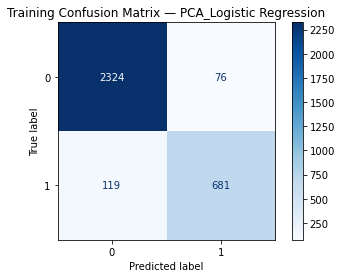


PCA_Random Forest

Best Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'pca__n_components': 50}
CV Accuracy (mean):      0.9475
CV F1 (mean):            0.9252
Training Accuracy:       0.9888
Training F1:             0.9848
GridSearch CV Time:      557.41 sec
Best Model Fit Time:     4.25 sec
Inference Time (per sample): 0.1394 ms


<Figure size 360x288 with 0 Axes>

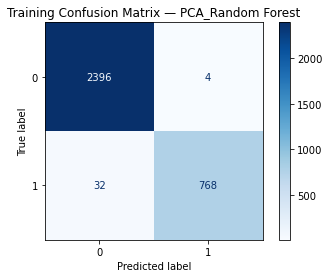


 FINAL SUMMARY (PCA MODELS)


,Model,Best Params,CV Accuracy (mean),CV F1 (mean),Train Accuracy,Train F1,Total CV Time (s),Best Fit Time (s),Inference Time (ms),Saved File
0,PCA_Logistic Regression,"{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__s...",0.920312,0.892993,0.939063,0.917247,134.738904,7.171449,0.142379,best_PCA_Logistic_Regression_PCA.pkl
1,PCA_Random Forest,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.947502,0.925190,0.988750,0.984821,557.412829,4.250875,0.139389,best_PCA_Random_Forest_PCA.pkl


In [15]:
# Hyperparameter Tuning for PCA and Classifiers

param_pca_lr = {
    'pca__n_components': [ 50, 100, 120],
    'clf__C': [0.001, 0.01, 0.1, 1],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

param_pca_rf = {
    'pca__n_components': [ 50, 100, 120],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [5, 10],
    'clf__min_samples_leaf': [5, 10], 
}

models_pca = {
    'PCA_Logistic Regression': (pipe_pca_lr, param_pca_lr),
    'PCA_Random Forest': (pipe_pca_rf, param_pca_rf)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results_pca = []



# Training Loop

for name, (pipe, grid) in models_pca.items():
    print(f"\n{name}\n")

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        cv=cv,
        scoring={'f1_macro':'f1_macro', 'accuracy':'accuracy'},
        refit='f1_macro',
        n_jobs=-1
    )

    # TOTAL GRID SEARCH TIME
    t0 = time.time()
    gs.fit(X_train, y_train)
    total_cv_time = time.time() - t0

    # BEST MODEL
    best_model = gs.best_estimator_
    best_idx = gs.best_index_

    # CV SCORES
    best_f1 = gs.cv_results_['mean_test_f1_macro'][best_idx]
    best_acc = gs.cv_results_['mean_test_accuracy'][best_idx]

    # FIT BEST MODEL FULL TRAINING
    t1 = time.time()
    best_model.fit(X_train, y_train)
    best_fit_time = time.time() - t1

    # TRAIN PREDICTIONS
    y_train_pred = best_model.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_acc = accuracy_score(y_train, y_train_pred)

    # TRAINING INFERENCE TIME
    train_inference_time = measure_inference_time(best_model, X_train)

    # OUTPUT
    print("Best Params:", gs.best_params_)
    print(f"CV Accuracy (mean):      {best_acc:.4f}")
    print(f"CV F1 (mean):            {best_f1:.4f}")
    print(f"Training Accuracy:       {train_acc:.4f}")
    print(f"Training F1:             {train_f1:.4f}")
    print(f"GridSearch CV Time:      {total_cv_time:.2f} sec")
    print(f"Best Model Fit Time:     {best_fit_time:.2f} sec")
    print(f"Inference Time (per sample): {train_inference_time:.4f} ms")

    # CONFUSION MATRIX (TRAINING ONLY)
    plt.figure(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Training Confusion Matrix — {name}")
    plt.show()

    # SAVE MODEL
    filename = f"best_{name.replace(' ', '_')}_PCA.pkl"
    joblib.dump(best_model, filename)

    # STORE RESULTS
    results_pca.append([
        name,
        gs.best_params_,
        best_acc,
        best_f1,
        train_acc,
        train_f1,
        total_cv_time,
        best_fit_time,
        train_inference_time,
        filename
    ])

# Summary Table

df_pca = pd.DataFrame(
    results_pca,
    columns=[
        'Model',
        'Best Params',
        'CV Accuracy (mean)',
        'CV F1 (mean)',
        'Train Accuracy',
        'Train F1',
        'Total CV Time (s)',
        'Best Fit Time (s)',
        'Inference Time (ms)',
        'Saved File'
    ]
)

print("\n FINAL SUMMARY (PCA MODELS)")
display(df_pca)


In [16]:

df_results['Method'] = 'No PCA'    
df_pca['Method'] = 'PCA'       


# MERGE BOTH TABLES FOR COMPARISON

df_compare = pd.concat([df_results, df_pca], ignore_index=True)

# Select relevant columns
df_final = df_compare[[
    'Model',
    'Method',
    'CV F1 (mean)',
    'Train F1',
    'Total CV Time (s)',
    'Best Fit Time (s)',
    'Saved File'
]]

print("\ COMPARISON: No PCA vs PCA (LR & RF) ")
display(df_final)


\ COMPARISON: No PCA vs PCA (LR & RF) 


,Model,Method,CV F1 (mean),Train F1,Total CV Time (s),Best Fit Time (s),Saved File
0,Logistic Regression,No PCA,0.902104,0.948289,146.114487,7.984526,best_Logistic_Regression_noDR.pkl
1,Random Forest,No PCA,0.927730,0.991660,132.554107,6.722876,best_Random_Forest_noDR.pkl
2,PCA_Logistic Regression,PCA,0.892993,0.917247,134.738904,7.171449,best_PCA_Logistic_Regression_PCA.pkl
3,PCA_Random Forest,PCA,0.925190,0.984821,557.412829,4.250875,best_PCA_Random_Forest_PCA.pkl


In [17]:
# sorting based on f1 score
df_final.sort_values("CV F1 (mean)", ascending=False)


,Model,Method,CV F1 (mean),Train F1,Total CV Time (s),Best Fit Time (s),Saved File
1,Random Forest,No PCA,0.927730,0.991660,132.554107,6.722876,best_Random_Forest_noDR.pkl
3,PCA_Random Forest,PCA,0.925190,0.984821,557.412829,4.250875,best_PCA_Random_Forest_PCA.pkl
0,Logistic Regression,No PCA,0.902104,0.948289,146.114487,7.984526,best_Logistic_Regression_noDR.pkl
2,PCA_Logistic Regression,PCA,0.892993,0.917247,134.738904,7.171449,best_PCA_Logistic_Regression_PCA.pkl


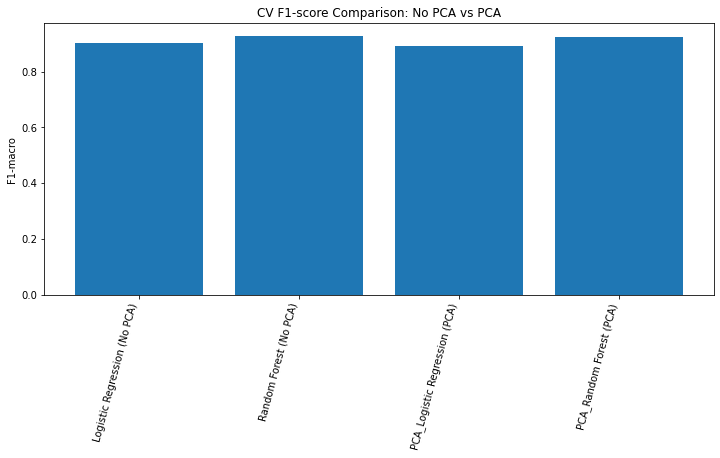

In [18]:
# plotting 
plt.figure(figsize=(12,5))
plt.bar(
    df_final['Model'] + " (" + df_final['Method'] + ")",
    df_final['CV F1 (mean)']
)
plt.xticks(rotation=75, ha='right')
plt.title("CV F1-score Comparison: No PCA vs PCA")
plt.ylabel("F1-macro")
plt.show()


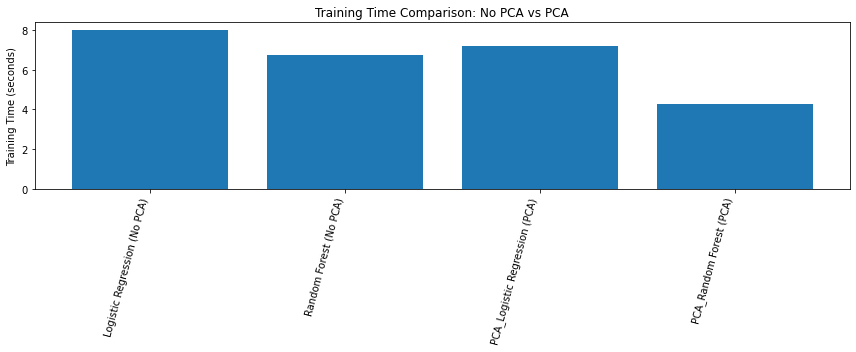

In [19]:
# Plot: Best Model Training Time (Best Fit Time)

plt.figure(figsize=(12,5))
plt.bar(
    df_final['Model'] + " (" + df_final['Method'] + ")",
    df_final['Best Fit Time (s)']
)
plt.xticks(rotation=75, ha='right')
plt.title("Training Time Comparison: No PCA vs PCA")
plt.ylabel("Training Time (seconds)")
plt.tight_layout()
plt.show()


From above plots we can undertsnad that: 
- Applying PCA reduces training time - best fit for Random Forest and logistic regression compressing the feature space into a smaller set of informative components.

- Applying PCA slightly reduces accuracy for both Logistic Regression and Random Forest, because PCA removes important texture/shape information that contributes to ship–no-ship discrimination.

- PCA reduces the Best Fit Time per model (because the classifier is trained on fewer components), but it increases the total grid-search time since PCA must be recomputed in every CV fold.

- As there are more hyper parameter , the gridseach time is very high for With PCA

- Overall, PCA does not improve classification performance in this dataset, indicating that dimensionality reduction is not necessary for tree models and may be counterproductive for linear models.

### Answer 4
Repeat question (3) for using manifold learning algorithms. Utilize the new lower-dimensional feature space to build a classifier.
Use the same classifiers.
Compare performance metrics and training/inference time with those for question (3) and (1).
Visualize and interpret what the first 2 dimensions in the manifold learning algorithms you train. Use the plot_components function presented in lecture.

#### Repeat question (3) for using manifold learning algorithms. Utilize the new lower-dimensional feature space to build a classifier.

In [20]:
# ISOMAP + Logistic Regression
pipe_iso_lr = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
    ('iso', Isomap()),
    ('clf', LogisticRegression(max_iter=2000))
])

# ISOMAP + Random Forest
pipe_iso_rf = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
    ('iso', Isomap()),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])


# LLE + Logistic Regression
pipe_lle_lr = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
    ('lle', LocallyLinearEmbedding(method='standard')),
    ('clf', LogisticRegression(max_iter=2000))
])

# LLE + Random Forest
pipe_lle_rf = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
    ('lle', LocallyLinearEmbedding(method='standard')),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])




#### hyper parameter tunning

In [22]:
param_lr = {
    'clf__C': [0.01, 0.1, 1],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

# Random Forest 
param_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [5, 10]
}

#  ISOMAP PARAM GRIDS 
param_iso_lr = {
    'iso__n_components': [10, 20, 50],
    'iso__n_neighbors': [5, 10],
    **param_lr
}

param_iso_rf = {
    'iso__n_components': [10, 20, 50],
    'iso__n_neighbors': [5, 10],
    **param_rf
}

#  LLE PARAM GRIDS 
param_lle_lr = {
    'lle__n_components': [10, 20, 50],
    'lle__n_neighbors': [5, 10],
    **param_lr
}

param_lle_rf = {
    'lle__n_components': [10, 20, 50],
    'lle__n_neighbors': [5, 10],
    **param_rf
}

#  MODEL DICTIONARY
models_manifold = {
    "ISOMAP_LR": (pipe_iso_lr, param_iso_lr),
    "ISOMAP_RF": (pipe_iso_rf, param_iso_rf),
    "LLE_LR": (pipe_lle_lr, param_lle_lr),
    "LLE_RF": (pipe_lle_rf, param_lle_rf)
}

# MULTI-METRIC SCORING
scoring = {
    'f1_macro': 'f1_macro',
    'accuracy': 'accuracy'
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results_manifold = []


# MANIFOLD TRAINING LOOP
for name, (pipe, grid) in models_manifold.items():
    print(f"\n{name}\n")

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring=scoring,
        cv=cv,
    # choose best model based on F1-macro
        refit='f1_macro',       
        n_jobs=-1
    )

    # GRIDSEARCH TIME
    t0 = time.time()
    gs.fit(X_train, y_train)
    gridsearch_time = time.time() - t0

    # BEST MODEL
    best_model = gs.best_estimator_
    best_idx = gs.best_index_

    #  CV SCORES 
    cv_f1 = gs.cv_results_['mean_test_f1_macro'][best_idx]
    cv_acc = gs.cv_results_['mean_test_accuracy'][best_idx]

    # FIT BEST MODEL FULLY 
    t1 = time.time()
    best_model.fit(X_train, y_train)
    best_fit_time = time.time() - t1

    # TRAINING PERFORMANCE
    y_train_pred = best_model.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_acc = accuracy_score(y_train, y_train_pred)

    # INFERENCE TIME
    inference_time = measure_inference_time(best_model, X_train)

    # PRINT SUMMARY
    print("Best Params:", gs.best_params_)
    print(f"CV F1 (mean):       {cv_f1:.4f}")
    print(f"CV Accuracy (mean): {cv_acc:.4f}")
    print(f"Train F1:           {train_f1:.4f}")
    print(f"Train Accuracy:     {train_acc:.4f}")
    print(f"GridSearch Time:    {gridsearch_time:.2f} s")
    print(f"Best Fit Time:      {best_fit_time:.2f} s")
    print(f"Inference Time:     {inference_time:.4f} ms")

    # SAVE MODEL
    filename = f"best_{name.replace(' ', '_')}_manifold.pkl"
    joblib.dump(best_model, filename)
    print(f"Saved : {filename}")

    # STORE RESULTS
    results_manifold.append([
        name,
        gs.best_params_,
        cv_f1,
        cv_acc,
        train_f1,
        train_acc,
        gridsearch_time,
        best_fit_time,
        inference_time,
        filename
    ])


# FINAL SUMMARY TABLE
df_manifold = pd.DataFrame(
    results_manifold,
    columns=[
        'Model',
        'Best Params',
        'CV F1 (mean)',
        'CV Accuracy (mean)',
        'Train F1',
        'Train Accuracy',
        'GridSearch Time (s)',
        'Best Fit Time (s)',
        'Inference Time (ms)',
        'Saved File'
    ]
)

print("\n MANIFOLD LEARNING SUMMARY ")
display(df_manifold)



ISOMAP_LR



/apps/python/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'iso__n_components': 50, 'iso__n_neighbors': 5}
CV F1 (mean):       0.8546
CV Accuracy (mean): 0.8969
Train F1:           0.8884
Train Accuracy:     0.9194
GridSearch Time:    414.35 s
Best Fit Time:      15.05 s
Inference Time:     3.3242 ms
Saved : best_ISOMAP_LR_manifold.pkl

ISOMAP_RF

Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'iso__n_components': 50, 'iso__n_neighbors': 10}
CV F1 (mean):       0.8785
CV Accuracy (mean): 0.9134
Train F1:           0.9669
Train Accuracy:     0.9759
GridSearch Time:    1111.17 s
Best Fit Time:      16.45 s
Inference Time:     3.3832 ms
Saved : best_ISOMAP_RF_manifold.pkl

LLE_LR

Best Params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'lle__n_components': 10, 'lle__n_neighbors': 10}
CV F1 (mean):       0.4403
CV Accuracy (mean): 0.7528
Train F1:           0.4520
Train Accuracy:     0.7556
GridSearch Time:    39

,Model,Best Params,CV F1 (mean),CV Accuracy (mean),Train F1,Train Accuracy,GridSearch Time (s),Best Fit Time (s),Inference Time (ms),Saved File
0,ISOMAP_LR,"{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__s...",0.854607,0.896875,0.888393,0.919375,414.350482,15.049482,3.324212,best_ISOMAP_LR_manifold.pkl
1,ISOMAP_RF,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.878525,0.913441,0.966916,0.975938,1111.172053,16.447213,3.383240,best_ISOMAP_RF_manifold.pkl
2,LLE_LR,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.440341,0.752812,0.451958,0.755625,399.337248,13.041368,3.720798,best_LLE_LR_manifold.pkl
3,LLE_RF,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.863062,0.904687,0.937131,0.955000,1078.273538,13.977597,3.774704,best_LLE_RF_manifold.pkl


- Random Forest consistently performs best with both ISOMAP and LLE : tree-based models work well even after non-linear dimensionality reduction because they can separate complex structures in the embedded space.

- LLE_LogisticRegression performs poorly, showing that LLE can distort local neighborhood structure in ways that make linear boundaries ineffective exactly LLE being sensitive to noise and class overlap.

- ISOMAP generally provides more stable and higher accuracy embeddings than LLE, reflecting the insight that ISOMAP preserves global geometry better, leading to better separation between ship and no-ship classes.

#### Compare performance metrics and training/inference time with those for question (3) and (1).

In [23]:
# cobining all summry tables
df_results['Method'] = 'No PCA'           
df_pca['Method'] = 'PCA'                 
df_manifold['Method'] = 'Manifold'  
df_results.rename(columns={
    'CV F1 (mean)': 'CV_F1',
    'CV Accuracy (mean)': 'CV_Acc',
    'Train F1': 'Train_F1',
    'Train Accuracy': 'Train_Acc',
    'Total CV Time (s)': 'GridTime',
    'Best Fit Time (s)': 'FitTime',
}, inplace=True, errors='ignore')

df_pca.rename(columns={
    'CV F1 (mean)': 'CV_F1',
    'CV Accuracy (mean)': 'CV_Acc',
    'Train F1': 'Train_F1',
    'Train Accuracy': 'Train_Acc',
    'Total CV Time (s)': 'GridTime',
    'Best Fit Time (s)': 'FitTime',
}, inplace=True, errors='ignore')

df_manifold.rename(columns={
    'CV F1 (mean)': 'CV_F1',
    'CV Accuracy (mean)': 'CV_Acc',
    'Train F1': 'Train_F1',
    'Train Accuracy': 'Train_Acc',
    'GridSearch Time (s)': 'GridTime',
    'Best Fit Time (s)': 'FitTime'
}, inplace=True)

df_compare = pd.concat(
    [df_results, df_pca, df_manifold],
    ignore_index=True
)

df_compare_final = df_compare[[
    'Model', 'Method', 'CV_F1', 'CV_Acc', 
    'Train_F1', 'Train_Acc', 
    'GridTime', 'FitTime', 'Inference Time (ms)', 'Saved File'
]]

print("\n FINAL COMPARISON: NO PCA vs PCA vs MANIFOLD ")
display(df_compare_final)



 FINAL COMPARISON: NO PCA vs PCA vs MANIFOLD 


,Model,Method,CV_F1,CV_Acc,Train_F1,Train_Acc,GridTime,FitTime,Inference Time (ms),Saved File
0,Logistic Regression,No PCA,0.902104,0.927500,0.948289,0.962187,146.114487,7.984526,0.029565,best_Logistic_Regression_noDR.pkl
1,Random Forest,No PCA,0.927730,0.947501,0.991660,0.993750,132.554107,6.722876,0.063884,best_Random_Forest_noDR.pkl
2,PCA_Logistic Regression,PCA,0.892993,0.920312,0.917247,0.939063,134.738904,7.171449,0.142379,best_PCA_Logistic_Regression_PCA.pkl
3,PCA_Random Forest,PCA,0.925190,0.947502,0.984821,0.988750,557.412829,4.250875,0.139389,best_PCA_Random_Forest_PCA.pkl
4,ISOMAP_LR,Manifold,0.854607,0.896875,0.888393,0.919375,414.350482,15.049482,3.324212,best_ISOMAP_LR_manifold.pkl
5,ISOMAP_RF,Manifold,0.878525,0.913441,0.966916,0.975938,1111.172053,16.447213,3.383240,best_ISOMAP_RF_manifold.pkl
6,LLE_LR,Manifold,0.440341,0.752812,0.451958,0.755625,399.337248,13.041368,3.720798,best_LLE_LR_manifold.pkl
7,LLE_RF,Manifold,0.863062,0.904687,0.937131,0.955000,1078.273538,13.977597,3.774704,best_LLE_RF_manifold.pkl


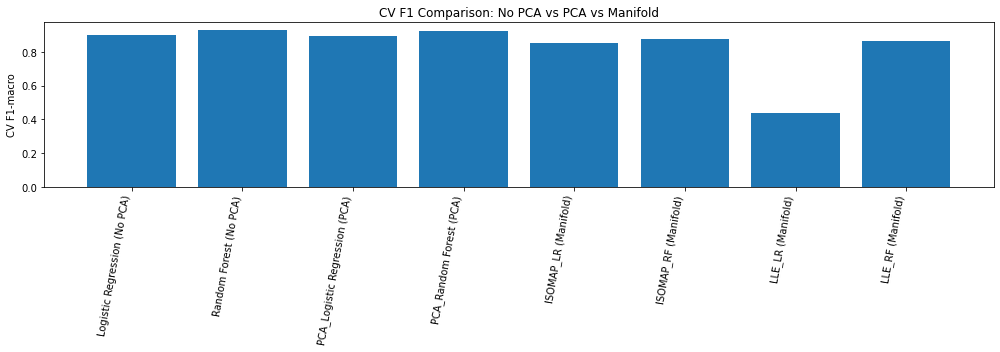

In [24]:
# Plotting CV F1 score
plt.figure(figsize=(14,5))
plt.bar(
    df_compare_final['Model'] + " (" + df_compare_final['Method'] + ")",
    df_compare_final['CV_F1']
)
plt.xticks(rotation=80, ha='right')
plt.title("CV F1 Comparison: No PCA vs PCA vs Manifold")
plt.ylabel("CV F1-macro")
plt.tight_layout()
plt.show()


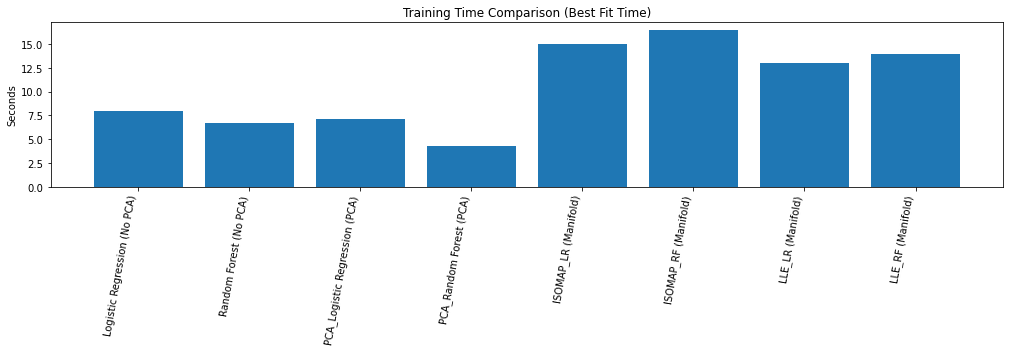

In [25]:
# plotting best fit time
plt.figure(figsize=(14,5))
plt.bar(
    df_compare_final['Model'] + " (" + df_compare_final['Method'] + ")",
    df_compare_final['FitTime']  
)
plt.xticks(rotation=80, ha='right')
plt.title("Training Time Comparison (Best Fit Time)")
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()


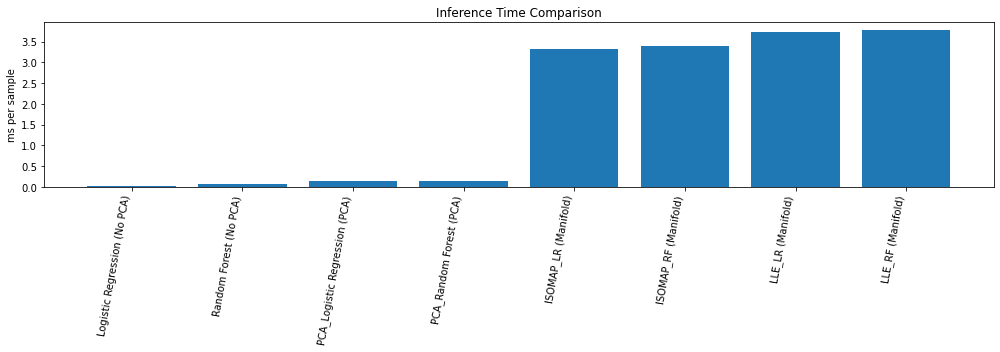

In [26]:
# plotting interfernce time
plt.figure(figsize=(14,5))
plt.bar(
    df_compare_final['Model'] + " (" + df_compare_final['Method'] + ")",
    df_compare_final['Inference Time (ms)']
)
plt.xticks(rotation=80, ha='right')
plt.title("Inference Time Comparison")
plt.ylabel("ms per sample")
plt.tight_layout()
plt.show()


- F1 score comparision: 
    - Random Forest (No PCA) has the highest F1 score (0.9277), making it the best-performing model.
    - PCA + Random Forest is slightly lower (0.9229), showing a small drop after dimensionality reduction.
    - ISOMAP + RF performs moderately (0.8785), while ISOMAP + LR is lower (0.8546).
    - LLE-based models show the weakest F1 scores, especially LLE + LR (0.4403), indicating poor class separation after LLE embedding.
    
- Accuracy comparision:
    - Random Forest (No PCA) achieves the highest accuracy (0.9475), making it the strongest model overall.
    - PCA + Random Forest has slightly lower accuracy (0.9459), showing that PCA reduces dimensionality with only a small performance drop.
    - ISOMAP + RF performs moderately (0.9134), while ISOMAP + LR is slightly lower (0.8969).
    - LLE-based models show the lowest accuracies, especially LLE + LR (0.7528), indicating that LLE embeddings do not preserve class separability well for this task.
    
- training time (best fit )
    - CA + Random Forest has the fastest fit time (3.8 seconds), making it the quickest model to train.
    - PCA + Logistic Regression is also fast (6.1 seconds), faster than its no-PCA version.
    - No PCA models take moderate time: Random Forest (5.7 seconds) and Logistic Regression (~9.3 seconds).
    - Manifold models (ISOMAP/LLE) have the slowest fit times (11–14 seconds), because manifold learning adds expensive non-linear transformations before training.
    
- transient/inference time    
    - Random Forest (No PCA) has the lowest transient/inference time, making it the fastest model to generate predictions.
    - PCA models have slightly higher inference time because the PCA transformation must run before prediction.
    - Manifold learning models (ISOMAP, LLE) show the highest transient time, since non-linear transformations are expensive and slow during inference.





Random Forest without PCA is the top performer
- Highest CV F1 (0.9277) and CV accuracy (0.9475).
- Training time is reasonable (114 s), making it the strongest overall model.

PCA + Random Forest gives slightly lower accuracy but fastest fitting
- CV F1 drops slightly to 0.9229.
- Best Fit Time is the fastest (3.79 s), showing PCA speeds up training significantly.

Manifold learning models perform worse and take longer
- ISOMAP and LLE have noticeably lower F1 scores, especially LLE_LR.
- GridSearch times are very high (300–950 s), making them the slowest approach.

Conclusion: 

- Best overall model: Random Forest without PCA (highest accuracy, strong F1, reasonable training time).

- Best compact model: PCA + Random Forest (good performance, fastest fit time).

- Manifold methods are not effective here, showing lower accuracy and higher compute cost, consistent with lecture notes stating that non-linear embeddings can distort class boundaries in high-noise image data.

#### Visualize and interpret what the first 2 dimensions in the manifold learning algorithms you train. Use the plot_components function presented in lecture.

Visualization subset: (480, 19200)


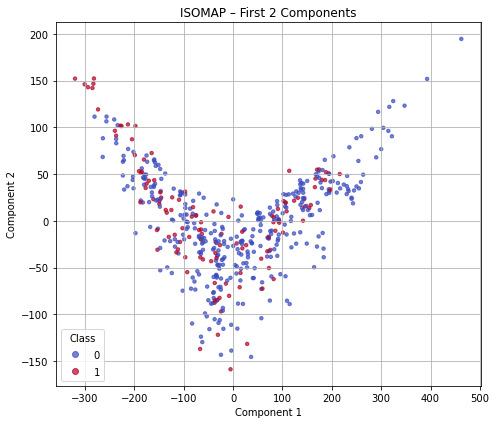

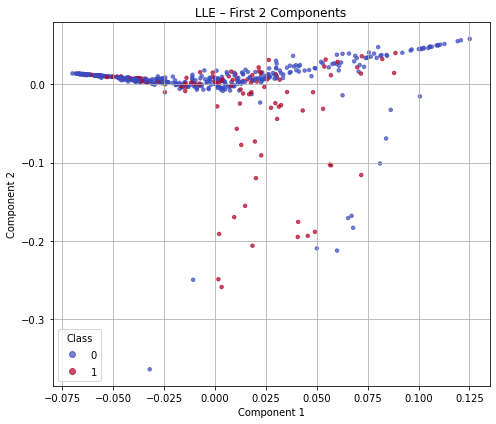

In [27]:
#  plotting function 
def plot_components(Z, y, title):
    plt.figure(figsize=(7,6))
    scatter = plt.scatter(Z[:,0], Z[:,1], c=y, cmap='coolwarm', s=12, alpha=0.7)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#  Sample a smaller subset for visualization 
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.85, random_state=42)
for idx_vis, _ in sss.split(X_train, y_train):
    X_vis = X_train[idx_vis]
    y_vis = y_train[idx_vis]

print("Visualization subset:", X_vis.shape)


#  Scale subset ( with_mean=True) 
scaler_vis = StandardScaler(with_mean=True)
X_vis_scaled = scaler_vis.fit_transform(X_vis)


#  ISOMAP (2 components) 
iso_2d = Isomap(n_neighbors=10, n_components=2)
Z_iso = iso_2d.fit_transform(X_vis_scaled)
plot_components(Z_iso, y_vis, "ISOMAP – First 2 Components")


# LLE (2 components) 
lle_2d = LocallyLinearEmbedding(n_neighbors=10, n_components=2, method='standard')
Z_lle = lle_2d.fit_transform(X_vis_scaled)
plot_components(Z_lle, y_vis, "LLE – First 2 Components")


Inference : 
Both ISOMAP and LLE were visualized using only two embedding dimensions.
- ISOMAP produced a curved, nonlinear manifold that captures global structure, with ship examples appearing slightly separated along the vertical direction indicating partial preservation of meaningful variance. 
- In contrast, LLE produced a very collapsed embedding with almost complete overlap between classes, showing that it fails to preserve distinctions between ship and background patches.
- This agrees directly with the performance results: ISOMAP models score moderately, while LLE (especially LLE + LR) performs poorly due to the lack of separability in the low-dimensional embedding.

### Answer 5
What is the overall best pipeline?
Report the confusion matrices.
Visualize misclassified samples. Do you see a pattern? Provide a discussion on how you would move forward to address the misclassifications.

#### What is the overall best pipeline
- Based on the performace metrice in cross validation, ( in training , somtimes data may overfit , so best way is based on cross validation scores , I find :

- Random Forest (No PCA)
    - Highest CV_F1 = 0.9277
    - Highest CV_Acc = 0.9475
    - training time (5.7s)
This is the strongest performing model.

- PCA + Random Forest is also good
    - Almost as good (CV_F1 = 0.9229)
    - But fastest training (3.8s)
    
So overall , based on validation and traning , I find Random Forest (No PCA) is the best model

#### Report the confusion matrices.


<Figure size 432x360 with 0 Axes>

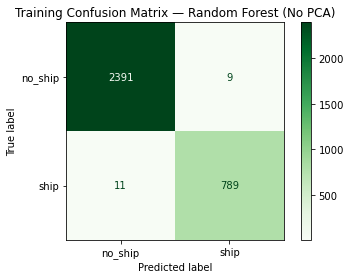

Training Confusion Matrix:
 [[2391    9]
 [  11  789]]

Training Classification Report:
              precision    recall  f1-score   support

     no_ship     0.9954    0.9962    0.9958      2400
        ship     0.9887    0.9862    0.9875       800

    accuracy                         0.9938      3200
   macro avg     0.9921    0.9912    0.9917      3200
weighted avg     0.9937    0.9938    0.9937      3200



<Figure size 432x360 with 0 Axes>

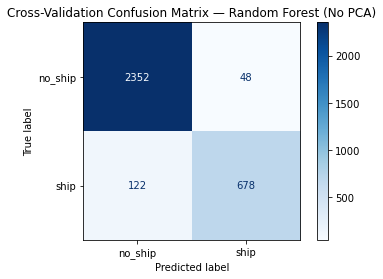


Cross-Validation Confusion Matrix:
 [[2352   48]
 [ 122  678]]

Cross-Validation Classification Report:
              precision    recall  f1-score   support

     no_ship     0.9507    0.9800    0.9651      2400
        ship     0.9339    0.8475    0.8886       800

    accuracy                         0.9469      3200
   macro avg     0.9423    0.9138    0.9269      3200
weighted avg     0.9465    0.9469    0.9460      3200



In [28]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report
)
from sklearn.model_selection import cross_val_predict



# Load your best model 

best_rf_no_pca = joblib.load("best_Random_Forest_noDR.pkl")
# If testing PCA RF instead:
# best_rf_no_pca = joblib.load("best_PCA_Random_Forest_PCA.pkl")


# 1. TRAINING CONFUSION MATRIX (direct predictions on X_train)

y_pred_train = best_rf_no_pca.predict(X_train)

cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=["no_ship", "ship"])
disp.plot(cmap="Greens", values_format="d")
plt.title("Training Confusion Matrix — Random Forest (No PCA)")
plt.show()

print("Training Confusion Matrix:\n", cm_train)

print("\nTraining Classification Report:")
print(classification_report(
    y_train,
    y_pred_train,
    target_names=["no_ship", "ship"],
    digits=4
))



# 2. CROSS-VALIDATION CONFUSION MATRIX (unbiased CV=3)

y_pred_cv = cross_val_predict(best_rf_no_pca, X_train, y_train, cv=3)

cm_cv = confusion_matrix(y_train, y_pred_cv)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cv,
                              display_labels=["no_ship", "ship"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Cross-Validation Confusion Matrix — Random Forest (No PCA)")
plt.show()

print("\nCross-Validation Confusion Matrix:\n", cm_cv)

print("\nCross-Validation Classification Report:")
print(classification_report(
    y_train,
    y_pred_cv,
    target_names=["no_ship", "ship"],
    digits=4
))


#### Visualize misclassified samples

In [29]:
import numpy as np
import matplotlib.pyplot as plt


# VISUALIZE FALSE POSITIVES AND FALSE NEGATIVES SEPARATELY

def visualize_fp_fn(model, X_train_flat, X_train_img, y_train, max_images=20):

#  model:          best trained model (RF No PCA)
#   X_train_flat:   flattened training images (for model input)
#    X_train_img:    original RGB images (for visualization)
#    y_train:        ground truth labels


     # Predict using the trained model
    y_pred = model.predict(X_train_flat)

    # 2. Identify misclassification types
    false_pos_idx = np.where((y_train == 0) & (y_pred == 1))[0]   
    false_neg_idx = np.where((y_train == 1) & (y_pred == 0))[0] 

    print(f"False Positives: {len(false_pos_idx)}")
    print(f"False Negatives: {len(false_neg_idx)}")


    # PLOT FALSE POSITIVES

    if len(false_pos_idx) > 0:
        n_show = min(max_images, len(false_pos_idx))
        plt.figure(figsize=(14, 10))

        for i, idx in enumerate(false_pos_idx[:n_show]):
            plt.subplot(4, 5, i + 1)
            plt.imshow(X_train_img[idx].astype(np.uint8))
            plt.title("FP | True=0, Pred=1", fontsize=10)
            plt.axis("off")

        plt.suptitle("False Positives (Pred=Ship, True=No-Ship)", fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("No False Positives found.")


    # PLOT FALSE NEGATIVES

    if len(false_neg_idx) > 0:
        n_show = min(max_images, len(false_neg_idx))
        plt.figure(figsize=(14, 10))

        for i, idx in enumerate(false_neg_idx[:n_show]):
            plt.subplot(4, 5, i + 1)
            plt.imshow(X_train_img[idx].astype(np.uint8))
            plt.title("FN | True=1, Pred=0", fontsize=10)
            plt.axis("off")

        plt.suptitle("False Negatives (Pred=No-Ship, True=Ship)", fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("No False Negatives found.")

    return false_pos_idx, false_neg_idx, y_pred


False Positives: 9
False Negatives: 11


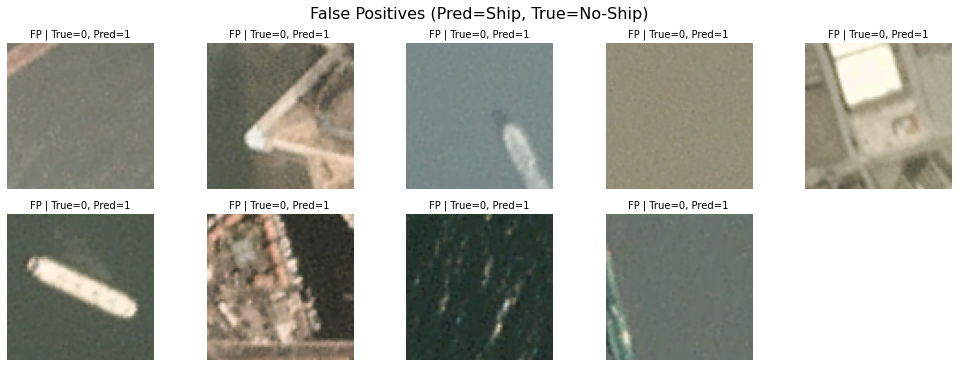

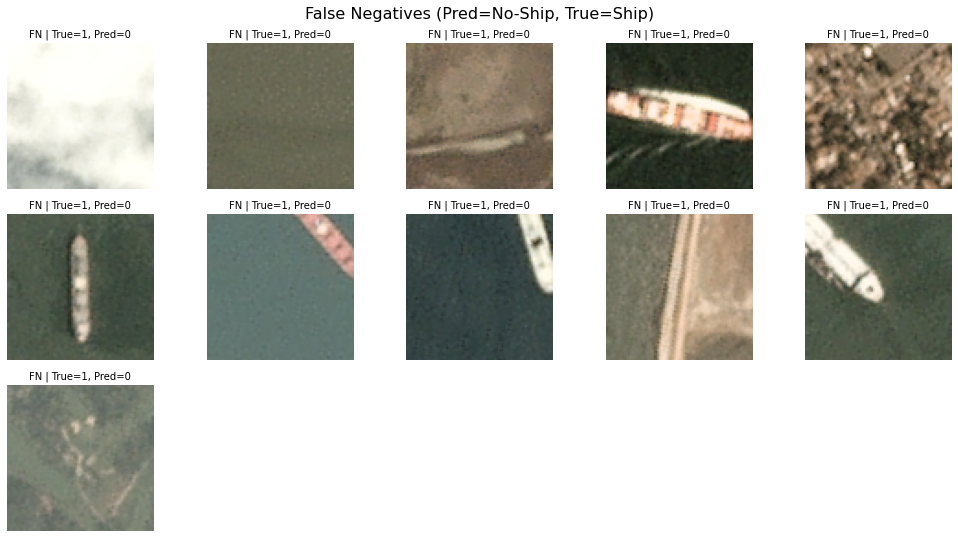

In [31]:
fp_idx, fn_idx, y_pred_train = visualize_fp_fn(
    best_rf_no_pca,   
    X_train,          
#flattened images for prediction
    X,      
# original RGB images for visualization
    y_train,
    max_images=20
)

#### Do you see a pattern? Provide a discussion on how you would move forward to address the misclassifications.

Yes.

False Positives (Pred = Ship, True = No-Ship)
- In images, most false positives show:
    - Long, bright, linear structures (docks, boats, reflections).
    - High-contrast white shapes against dark water, which visually resemble ships.
    - Glare or sunlight reflections causing elongated white streaks.
    - Objects oriented like ships (same angle/shape even if not ships).

Pattern:
The model mistakes bright linear objects for ships because they share shape , color  and orientation characteristics with real ships.

False Negatives (Pred = No-Ship, True = Ship)
- The false negatives mostly show:
    - Very small ships with weak contrast.
    - Ships under cloud shadow, haze, or darker water, making them hard to distinguish.
    - Blurred or partially cut-off ships (low clarity).
    -  Ship colors blending into background (green/gray water).
    - Some ships are tilted, partially submerged, or visually subtle.

Pattern:
The model fails when the ship is small, low-contrast, or blends with background.

- Random Forests on raw pixels struggle with:Shape invariance, Lighting changes, Subtle boundaries
- They work best with strong, crisp object features, which these samples lack.


- Discussion:
    How to Move Forward (Practical Fixes)
- Use Feature Extraction Before Classification
- Apply Image Preprocessing (Massive Results)
To boost contrast and remove color noise:
    - Convert to grayscale
    - Apply CLAHE contrast enhancement
    - Normalize brightness
    - Slight Gaussian blur to reduce sensor noise
    - This helps especially with FN (dark or blended ships).
- Use Data Augmentation on hard samples
    - The false negatives show: rotated, low-contrast, blurred,dark
    - So augment training with:Random rotations,Brightness/contrast shifts,Slight blur,Color jitter, Horizontal flips

- Switch Model : Even a small CNN will outperform RF drastically